In [1]:
%%capture
import os
import pandas as pd
from customLib.data_parser import load_database
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import customLib.autoencoder_helper as helper

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/ivanbrillo/tesiRFX
    %cd tesiRFX
    !rsync -a --exclude='*.ipynb' --exclude='*.git' ./ ../
    %cd..
    !rm -rf tesiRFX

In [2]:
database, _, _ = load_database("databse.pkl")

In [3]:
df = pd.DataFrame(database)
df['supply delay'] = df['supply delay'].replace('100s', '0d')
col_dict = {}

for cc in ['type', 'frequency', 'exposure time', 'supply delay']:
    df[cc] = pd.Categorical(df[cc])
    col_dict[cc.replace(" ", "_")] = len(pd.Categorical(df[cc]).categories)
    df[cc] = df[cc].cat.codes

In [4]:
def base_model(inputs):
    x= Dense(500, activation='tanh')(inputs)
    x= Dense(500, activation='tanh')(x)
    x= Dense(300, activation='tanh')(x)
    x= Dense(300, activation='tanh')(x)
    x= Dense(300, activation='tanh')(x)
    x= Dense(300, activation='tanh')(x)
    x= Dense(150, activation='tanh')(x)
    x= Dense(150, activation='tanh')(x)
    return x

def final_model(inputs):
    x = base_model(inputs)
    output_layers = [layers.Dense(v, activation='softmax', name=f'output_{k}')(x) for (k, v) in col_dict.items()]
    return Model(inputs=inputs, outputs = output_layers)

In [5]:
# df['frequency'] = df['frequency'].astype('category', categories=['12kHz', '20kHz', '900W'])
df['frequency'] = pd.Categorical(df['frequency'])

df_encoded = pd.get_dummies(df, columns=['type', 'frequency', 'exposure time', 'supply delay'])
y = []

for col_name in ['type', 'frequency', 'exposure time', 'supply delay']:
    frequency_columns = [col for col in df_encoded.columns if col_name in col]
    df_subset = df_encoded[frequency_columns]
    np_array = df_subset.values
    y.append(np_array)

In [6]:
from customLib.AE import AE, get_sequentials_outer

inputs = Input(shape=(80, ))
model = final_model(inputs)
model.compile(optimizer='adam',  loss = 'binary_crossentropy', metrics='accuracy', run_eagerly=True)

train_x = np.array([np.array(x) for x in df["time_data"]]) 
train_x = train_x.reshape((239, 1800, 1))

autoencoder = AE(*get_sequentials_outer())
train_x = autoencoder.encoder.predict(train_x, verbose=0)

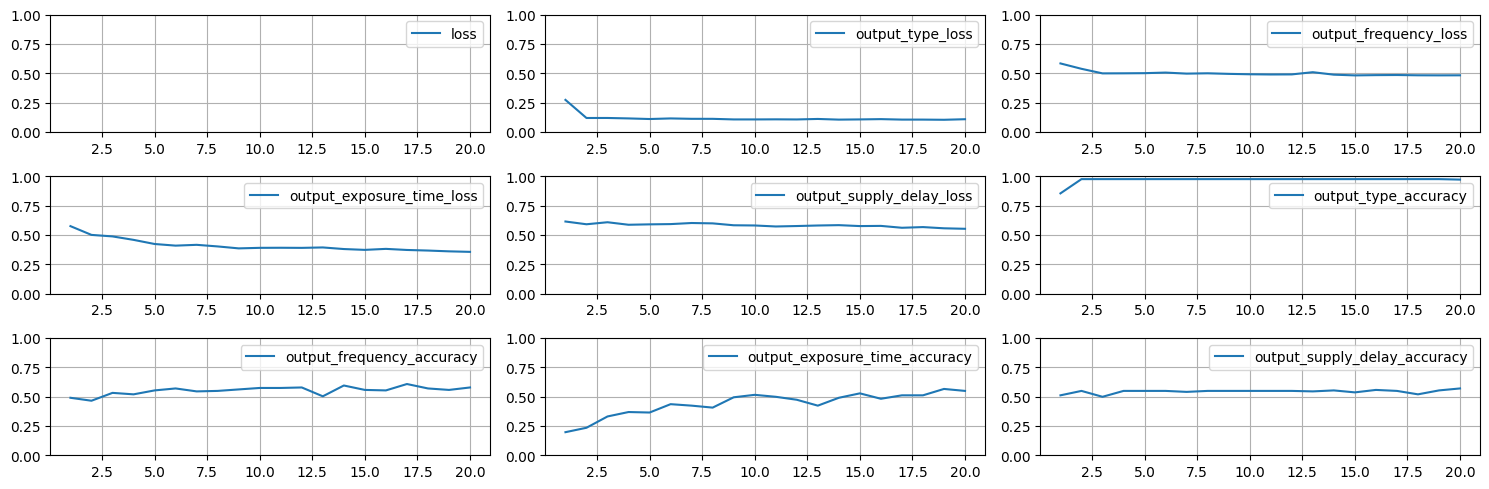

8/8 [==============================] - 4s 543ms/step - loss: 1.4978 - output_type_loss: 0.1083 - output_frequency_loss: 0.4822 - output_exposure_time_loss: 0.3555 - output_supply_delay_loss: 0.5519 - output_type_accuracy: 0.9707 - output_frequency_accuracy: 0.5774 - output_exposure_time_accuracy: 0.5481 - output_supply_delay_accuracy: 0.5690


In [7]:
from customLib.plot_learning import PlotLearning2
model.fit(train_x, y, epochs=20, callbacks=[PlotLearning2()])